In [24]:
import soundfile as sf
import os
import numpy as np
import pandas as pd
from scipy import fftpack
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

%matplotlib inline

### How to read in and process the data ### 

** The dat is in .WAV format. Going to use the sorundfile module to read in data **

1. Each file within a folder represents wave/data heartbeats within a category defined by dataset
    * User provided
        * Normal
        * Heart conditions:
    * Hospital recorded
        * Normal
        * Heart condition
2. We want to take a look at what the signals look like and how to perfrom data process 
    * How to handle N/A
    * How long each file is 
    * How to perform low-pass filtering

** Create a class that generates a series of helper functions for analyzing the data **

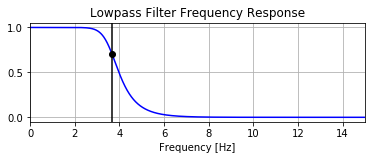

In [2]:
#   creating-lowpass-filter-in-scipy-understanding-methods-and-units
# Taken from  https://stackoverflow.com/questions/25191620/

from scipy.signal import butter, lfilter, freqz
from matplotlib import pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()




In [31]:
def filter_noise_old(signal, cutoff, samplerate):
    # print(len(signal))
    signal = signal[~np.isnan(signal)]
    # print(len(signal))
    X_fft = fftpack.fft(signal)
    freqs = fftpack.fftfreq(len(X_fft)) * samplerate
    X_fft[abs(freqs) > cutoff] = 0      
    # print(len(np.real(fftpack.ifft(X_fft)) ))
    return np.real(fftpack.ifft(X_fft))     

def filter_noise(signal, cutoff, samplerate, order=5):    
    # Filter the data, and plot both the original and filtered signals.
    return butter_lowpass_filter(signal, cutoff, samplerate, order)

    
def plot_data(signal, samplerate, plotme=True):
    if plotme:
        plt.plot(signal.dropna().index, signal.dropna().values, 'k')
    return go.Scatter(
        x=signal.dropna().index,
        y=signal.dropna().values
    )

def plot_fft(signal, samplerate, plotme=True):
    
    X_fft_no_pad = fftpack.fft(signal.dropna())
    # extract the frequencies from the FFT signal (scale frequencies by their sampling rate)
    freqs = fftpack.fftfreq(len(X_fft_no_pad)) * samplerate
    if plotme:
        plt.plot(freqs, np.abs(X_fft_no_pad), 'b')
    return go.Scatter(x=freqs, y=np.abs(X_fft_no_pad))    
    # return [freqs, np.abs(X_fft_no_pad)]
    

    
class heart_signal(object):
    """
    Create a class to store groups of .wav files 
    We can store statistics on the groups (such as file lengths and N/A)
    We can convert data into a dataframe and perform lowpass filtering
    """    
    
    def __init__(self, folder_path=None, files=None, autoread_files=False):
        """
        when initialized just store the location of all the data files containing .wav files to read in
        """
        self.provided_files = []
        self.autoread_files = autoread_files
        if not(folder_path is None):
            for r, dlist, flist in os.walk(path):
                """
                read in all files provided by folder
                """
                for f in flist:
                    if not(f.endswith('.wav')):
                        continue
                    name = os.path.join(r, f)
                    self.provided_files.append(name)
        if not (files is None):
            for name in files:                
                if os.path.isfile(name) and name.endswith('.wav'):
                    self.provided_files.append(name)
                else:
                    print('Invalid file {0}'.format(name))
        
        if len(self.provided_files) == 0:
            raise Exception
        
        if self.autoread_files:
            self.create_df()
        else:
            self.signal_df = None
        
        self.nan_free = None
                
    
    def create_df(self):
        """
            Read the .wav data into a dataframe where we collect the signal/sound data at the provided sampling rate
        """
        _, self.samplerate = sf.read(self.provided_files[0])
        
        signal_array = []
        data = []
        for name in self.provided_files:            
            signal, samplerate = sf.read(name)
            signal_array.append(list(signal))
            data.append({'name': name, 'basename': os.path.basename(name), 'samplerate': samplerate})
        
        self.data_df = pd.DataFrame(data)
        self.signal_df = pd.DataFrame(signal_array, index=self.data_df['basename'])
        
        if len(self.data_df['samplerate'].unique()) != 1:
            print('The sample rate seems to be different for the provided files!')
        else:
            # we can actually assign "time data" to the columns of the dataframe
            # the "time" will be given in intervals defined by the sampling rate
            time_values = np.arange(0, (self.signal_df.shape[1]*1.0)/self.samplerate, self.samplerate)
            # self.signal_df.rename(columns=lambda x: (1.0 * x)/self.samplerate, inplace=True)
            
    def get_signal_length_distribution(self, nbins=None):
        if self.signal_df is None:
            print('You must create_df() first!')
            return
        
        if nbins:
            return np.histogram(
                self.signal_df.apply(lambda x: len(x.dropna())/self.samplerate, axis=1)
            )
        else:
            return np.histogram(self.signal_df.apply(lambda x: len(x.dropna()), axis=1))
        
    def identify_null_values(self):
        """
        It makes sense for the data to have NaN at the end of the signal. This is because each .wav file is a different 
        length. But not sure if there is any NaN data in the middle of the file. So this makes sure there is only
        one spoint in the data that has Nan values (i.e. doesnt do 0 NaN 1 Nan 2 Nan Nan; but it can do 0 1 2 NaN NaN NaN)
        """
        check_for_nan = (normal_group.signal_df.isnull().diff(axis=1).iloc[:, 1:] == True).sum(axis=1)
        has_unusual_data = check_for_nan[check_for_nan>1]
        if has_unusual_data.shape[0] > 0:            
            self.nan_free = False
            print('WE found files with NaN in them')
        else:
            self.nan_free = True
            print('Files look good (no NaN in the middle)')
        return has_unusual_data.index
        
    def get_some_data(self, index, use_iloc=False):
        """
        return a copy of the signals
        """
        if use_iloc:            
            return self.signal_df.iloc[index].copy()
        else:            
            return self.signal_df.loc[index].copy()
        
    
    def pad_zero(self, check_nan_free = True):
        if check_nan_free and (self.nan_free is None or check_nan_free is False):
            print('Sorry I cannot do this function until I know all nan values have been handled correctly!')
            raise Exception
            return
            
        if self.nan_free is None:
            print("Warning: Im replacing all NaN points in the table with zeros but I havent checked if there are any Nan values in the middle of the dataset...this could screw up the results")
        elif self.nan_free is False:
            print('Warning: Im replacing all Nan points in the table with zeros but some datapoints with Nan are not at the end of the signal and might yield incorrect results')
        
        self.signal_df.fillna(0, inplace=True)
        
    def low_pass_filter(self, freq, limit=None, inplace=False):
        if limit:
            subsample = self.signal_df.iloc[:limit]
        else:
            subsample = self.signal_df
                                           
        new_data = [filter_noise(d, freq, self.samplerate) for d in subsample.values]
    
        new_data_df = pd.DataFrame(new_data, index=subsample.index)
        time_values = np.arange(0, (new_data_df.shape[1]*1.0)/self.samplerate, self.samplerate)
        # new_data_df.rename(columns=lambda x: (1.0 * x)/self.samplerate, inplace=True)
        
        if inplace:
            del self.signal_df
            self.signal_df = new_data_df
        else:
            return new_data_df
            
        
            
            

** Step 1) Read in normal heartbeat data (From the set_a) folder **

In [4]:
# define location
# path = './set_a'
df = pd.read_csv(
    './set_a/Atraining_normal_seg.csv', 
    index_col=0
)# .applymap(lambda x: (x*1.0)/normal_group.samplerate)

files = list(df.index.map(lambda x: os.path.join('./set_a/', 'normal', 'normal__'+'.'.join(x.split('.')[:-1]) + '.wav')))
# create instance
normal_group = heart_signal(files=files)
# read in wav data
normal_group.create_df()
# make sure there are no nan values before the end
# because this is empty there are no null values in the middle of the wav files
normal_group.identify_null_values()


Files look good (no NaN in the middle)


Index([], dtype='object', name=u'basename')

In [14]:
plt_plot(go.Figure(
    data=[plot_data(normal_group.signal_df.iloc[0], normal_group.samplerate)],
    layout=go.Layout(title='Sample data in time domain'),    
),image='png', image_filename='b.png', auto_open=False)
plt_plot(go.Figure(
    data=[plot_fft(normal_group.signal_df.iloc[0], normal_group.samplerate)],
    layout=go.Layout(title='Sample data in freq domain')    
),image='png', image_filename='a.png')

'file:///home/costas/GA/github/ga_assignments/PROJECT_HEARTBEAT/temp-plot.html'

Sample data in time domain


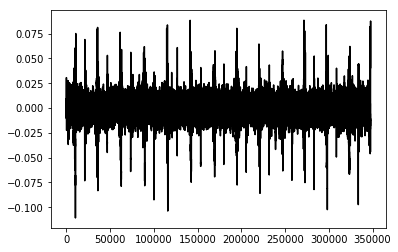

In [35]:
plot_data(normal_group.signal_df.iloc[0], normal_group.samplerate)
print('Sample data in time domain')

Sample data in freq domain


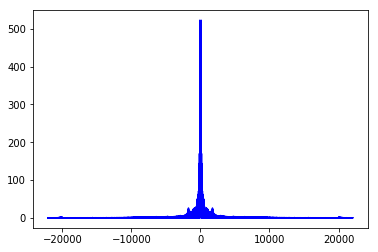

In [36]:
plot_fft(normal_group.signal_df.iloc[0], normal_group.samplerate)
print('Sample data in freq domain')

** Step 2: Filter out noisy data **

In [37]:
normal_group.low_pass_filter(20, inplace=True)

In [ ]:
iplot(go.Figure(
    data=[plot_data(normal_group.signal_df.iloc[0], normal_group.samplerate)],
    layout=go.Layout(title='Sample data with only low frequency')
))

Sample data after high frequency noise has been filtered


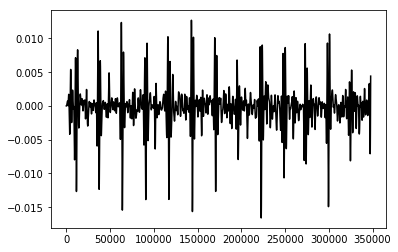

In [38]:
plot_data(normal_group.signal_df.iloc[0], normal_group.samplerate)
print('Sample data after high frequency noise has been filtered')

** Step 3: Overlay heartbeat sounds provided by training sets **

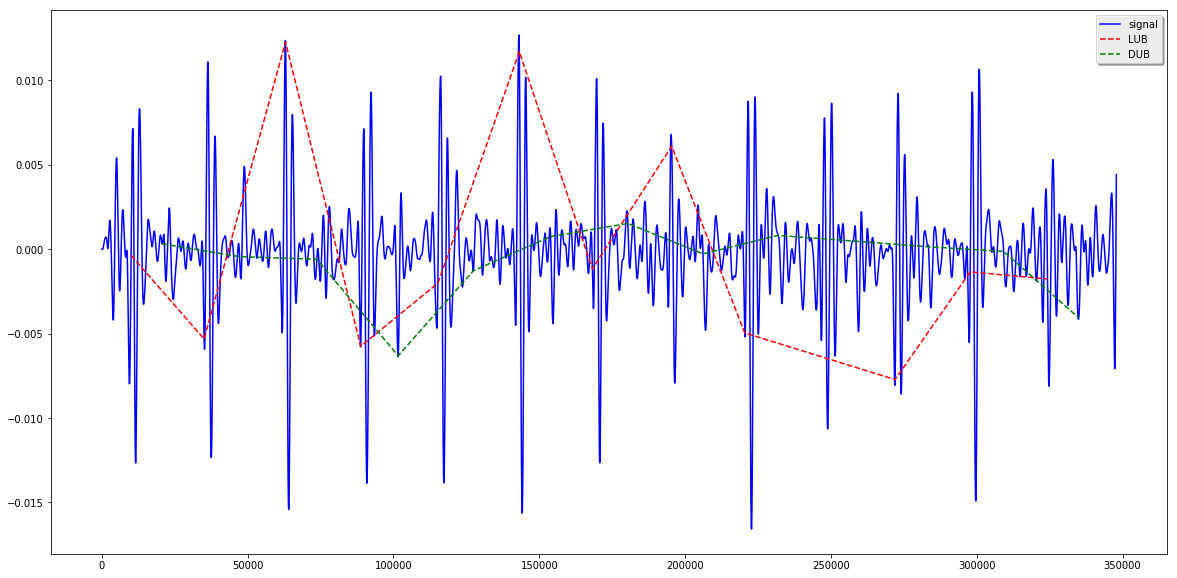

In [46]:
name = 'normal__' + df.index[0].replace('.aif', '.wav')
# normal_group = heart_signal(files=files)
# read in wav data
# normal_group.create_df()
# make sure there are no nan values before the end
# because this is empty there are no null values in the middle of the wav files
# normal_group.identify_null_values()

test = normal_group.get_some_data(name)
lub_dub = df.iloc[0]
lub_dub_groups = lub_dub.groupby(by=lambda x: x.split('.')[0]).groups
S1 = test[lub_dub[lub_dub_groups['S1']].dropna().values]
S2 = test[lub_dub[lub_dub_groups['S2']].dropna().values]
#iplot(
#    [
#        go.Scatter(x=test.index, y=test.values, name='data'),
#        go.Scatter(x=S1.index, y=S1.values, name='LUB'),
#        go.Scatter(x=S2.index, y=S2.values, name='DUB'),
#    ])
plt.figure(figsize=(20,10))
plt.plot(
    test.index, test.values, 'b',label='signal',
)
plt.plot(
S1.index, S1.values, '--r', label='LUB'
)
plt.plot(
    S2.index, S2.values, '--g',label='DUB'
)
plt.legend(loc='upper right', shadow=True)

